In [3]:
# Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from chart_studio import plotly
from plotly import __version__
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

## Loading Data Files

In [4]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')

# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
#Exploring data_variants
data_variants.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [6]:
#Getting data information
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
#Description for numeric columns
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [8]:
# Checking dimension of data
data_variants.shape

(3321, 4)

In [9]:
# Checking column in above data_variants
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [10]:
# Exploring data_text
data_text.head(10)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


In [11]:
#Getting data information
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [12]:
# Description for numeric columns
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [13]:
# Checking column in above data_text
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [14]:
# Checking the dimensions
data_text.shape

(3321, 2)

In [15]:
# We are trying to predict the class of cancer,hence we will check all the unique values that can be determined
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [16]:
# We would like to remove all stop words like a, is, an, the, ... so we are collecting all of them from nltk(Natural Language
# Toolkit) library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\ANUJ
[nltk_data]     OJHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def data_text_preprocess(total_text, ind, col):
    # Removing integer values from text data as that might not be important
    if type(total_text) is not int:
        string = ""
        # replacing all special characters with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bringing the whole text to lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [18]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [19]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head(10)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
5,5,CBL,V391I,4,oncogenic mutations monomeric casitas b lineag...
6,6,CBL,V430M,5,oncogenic mutations monomeric casitas b lineag...
7,7,CBL,Deletion,1,cbl negative regulator activated receptor tyro...
8,8,CBL,Y371H,4,abstract juvenile myelomonocytic leukemia jmml...
9,9,CBL,C384R,4,abstract juvenile myelomonocytic leukemia jmml...


# Cleaning the data, handling missing values

In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [21]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [22]:
# Cross checking the null values after imputation
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [23]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [24]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data now into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [25]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


# Distribution of data in train, test and validation set

In [29]:
train_class_distribution = train_df['Class'].value_counts().sort_values()
train_class_distribution

8     12
9     24
3     57
5    155
6    176
2    289
1    363
4    439
7    609
Name: Class, dtype: int64

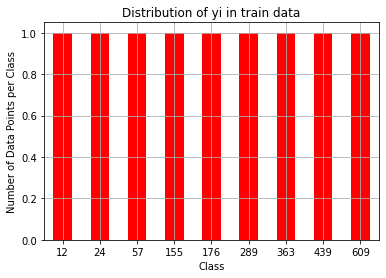

In [30]:
class_counts = train_class_distribution.value_counts()
class_percentages = class_counts / class_counts.sum() * 100
class_counts.plot(kind='bar', color='red')
plt.xlabel('Class')
plt.ylabel('Number of Data Points per Class')
plt.title('Distribution of yi in train data')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [31]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 9 : 609 ( 28.672 %)
Number of data points in class 8 : 439 ( 20.669 %)
Number of data points in class 7 : 363 ( 17.09 %)
Number of data points in class 6 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 4 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 2 : 24 ( 1.13 %)
Number of data points in class 1 : 12 ( 0.565 %)


In [ ]:
test_class_distribution = test_df['Class'].value_counts().sort_values()
test_class_distribution

8      4
9      7
3     18
5     48
6     55
2     91
1    114
4    137
7    191
Name: Class, dtype: int64

In [ ]:
df_train= pd.DataFrame(test_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Test Class Distribution',color = 'red')

In [ ]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 9 : 191 ( 28.722 %)
Number of data points in class 8 : 137 ( 20.602 %)
Number of data points in class 7 : 114 ( 17.143 %)
Number of data points in class 6 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 4 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 2 : 7 ( 1.053 %)
Number of data points in class 1 : 4 ( 0.602 %)


In [ ]:
cv_class_distribution = cv_df['Class'].value_counts().sort_values()
cv_class_distribution

8      3
9      6
3     14
5     39
6     44
2     72
1     91
4    110
7    153
Name: Class, dtype: int64

In [ ]:
df_train= pd.DataFrame(cv_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Validation Class Distribution',color = 'blue')

In [33]:
sorted_yi = np.argsort(-train_class_distribution.sort_values())
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

NameError: name 'cv_class_distribution' is not defined

Looking at the data point distribution for train, test and validation data we can safely say that the data distribution is similar in all the sets.

## Building a random model

In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

### Log loss of validation set 

In [ ]:
# Creating an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.489739234636341


### Log loss of test set

In [ ]:
# Creating an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.488292493876385


In [ ]:
# Getting the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

predicted_y

array([1, 5, 2, 0, 0, 3, 5, 1, 2, 5, 3, 0, 5, 4, 3, 1, 7, 4, 7, 7, 2, 4,
       3, 1, 0, 0, 7, 7, 0, 3, 5, 1, 1, 2, 8, 8, 7, 7, 7, 1, 0, 2, 5, 0,
       4, 6, 1, 6, 8, 0, 7, 7, 3, 6, 1, 0, 3, 4, 5, 4, 4, 2, 6, 7, 0, 2,
       3, 8, 6, 5, 0, 5, 1, 4, 6, 2, 0, 8, 7, 0, 0, 1, 1, 4, 3, 6, 4, 0,
       7, 4, 7, 3, 6, 8, 2, 8, 5, 6, 6, 4, 5, 1, 4, 0, 4, 8, 1, 7, 0, 7,
       4, 0, 4, 7, 8, 6, 3, 3, 5, 7, 3, 8, 3, 0, 3, 7, 0, 8, 0, 6, 0, 7,
       4, 3, 6, 3, 4, 6, 6, 2, 8, 4, 2, 4, 0, 1, 3, 4, 0, 6, 4, 8, 8, 6,
       5, 1, 0, 0, 1, 3, 2, 5, 7, 5, 8, 8, 7, 2, 8, 4, 0, 1, 1, 8, 7, 6,
       8, 8, 7, 7, 0, 5, 3, 4, 8, 8, 4, 5, 3, 6, 5, 0, 3, 4, 6, 8, 6, 4,
       4, 4, 7, 1, 8, 3, 8, 6, 8, 8, 8, 4, 2, 7, 5, 1, 2, 0, 2, 5, 5, 5,
       7, 7, 6, 1, 6, 7, 0, 4, 7, 3, 6, 5, 7, 0, 7, 6, 1, 2, 4, 7, 3, 3,
       5, 5, 0, 7, 7, 4, 7, 7, 4, 2, 8, 8, 4, 6, 4, 7, 3, 3, 0, 7, 2, 3,
       4, 3, 2, 0, 3, 5, 5, 6, 0, 2, 3, 7, 2, 4, 6, 3, 5, 7, 1, 6, 1, 0,
       5, 2, 3, 1, 4, 0, 2, 6, 6, 5, 8, 2, 7, 6, 2,

The index value ranges from 0 to 8. To rectify the value is increased by 1

In [ ]:
predicted_y = predicted_y + 1

## Confusion Matrix

In [ ]:
C = confusion_matrix(y_test, predicted_y)

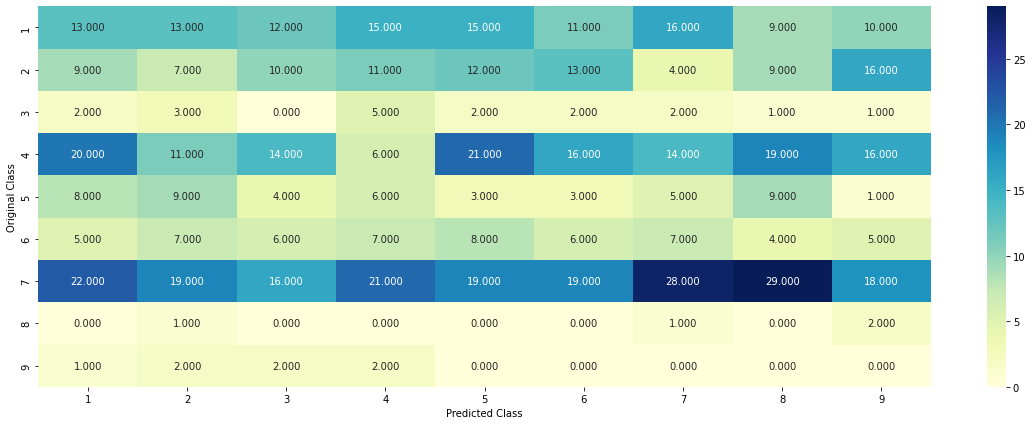

In [ ]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Precision Matrix

In [ ]:
B =(C/C.sum(axis=0))

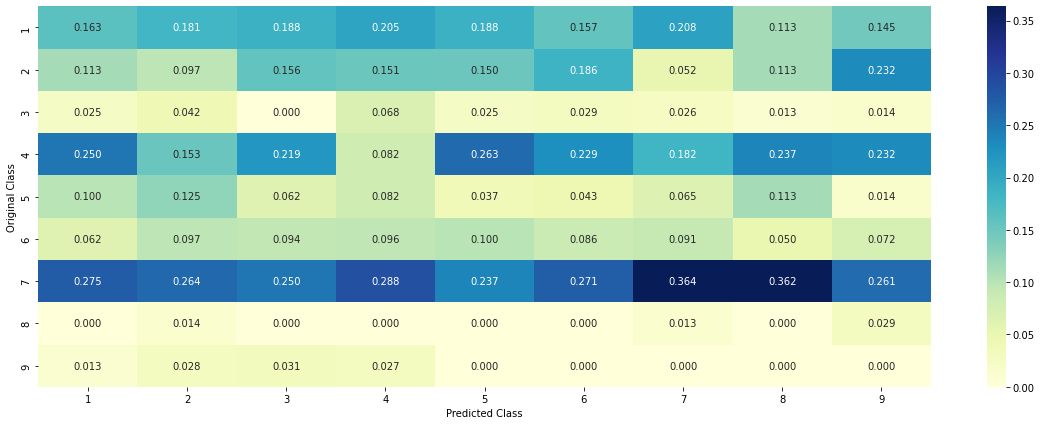

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Recall Matrix

In [ ]:
A =(((C.T)/(C.sum(axis=1))).T)

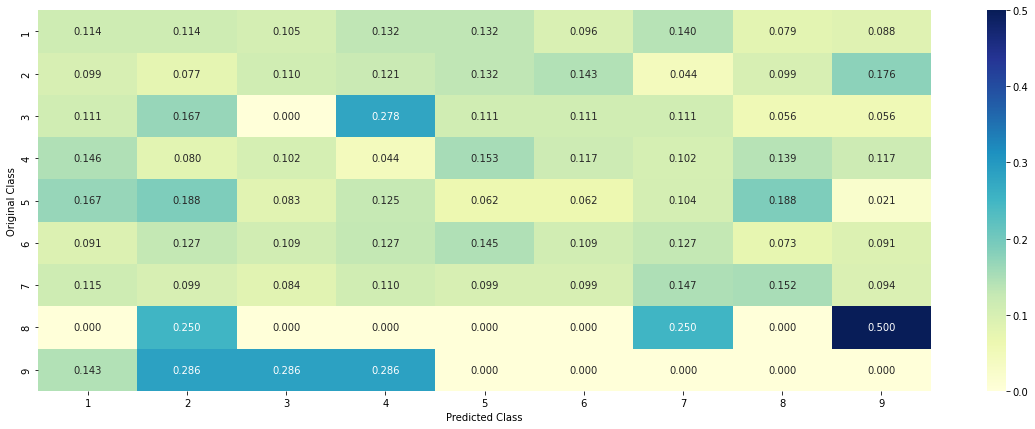

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Determining if the independent column gene is relevant to the target variable.

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 genes
print(unique_genes.head(10))

Number of Unique Genes : 234
BRCA1     164
TP53      107
EGFR       95
BRCA2      81
PTEN       81
KIT        65
BRAF       54
ERBB2      48
ALK        43
PIK3CA     35
Name: Gene, dtype: int64


Cumulative distribution of unique Genes values

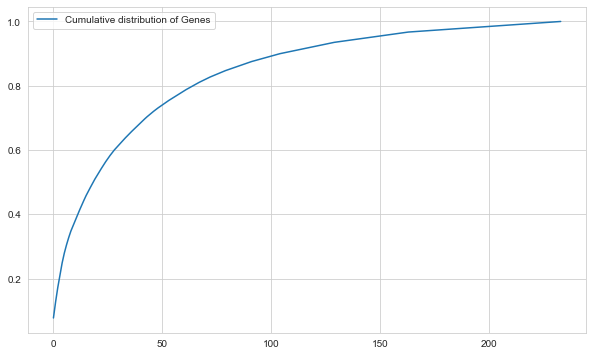

In [ ]:
sns.set_style('whitegrid')
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.figure(figsize =(10,6))
plt.plot(c,label='Cumulative distribution of Genes')
plt.legend()
plt.show()

In [ ]:
# One-hot encoding of gene feature
gene_vectorizer = CountVectorizer()
# Train gene feature
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
# Test gene feature
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
# CV gene feature
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

### Column generated after one hot encoding

In [ ]:
train_gene_feature_onehotCoding.shape

(2124, 234)

In [ ]:
# Column names after one-hot encoding for gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'jak1

Function for Response encoding of gene column

In [ ]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# ALGORITHIM
# -------------------------------------------------------------------------------------------------
# Considering all unique values and the number of occurences of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha /
#                                           number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there in train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ------------------------------------------------------------------------------------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to particular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### Response-coding of the gene feature

In [ ]:
# Alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Columns after applying response encoding

In [ ]:
train_gene_feature_responseCoding.shape

(2124, 9)

Determining if gene column is a good feature for predicting the target variable Class

In [ ]:
# Hyperparemeter for SGD(Stochastic Gradient Descent) classifier
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2099619723792538
For values of alpha =  0.0001 The log loss is: 1.1953178455364262
For values of alpha =  0.001 The log loss is: 1.2511239445115685
For values of alpha =  0.01 The log loss is: 1.3696013964523224
For values of alpha =  0.1 The log loss is: 1.4492726650492624
For values of alpha =  1 The log loss is: 1.4788684089492758


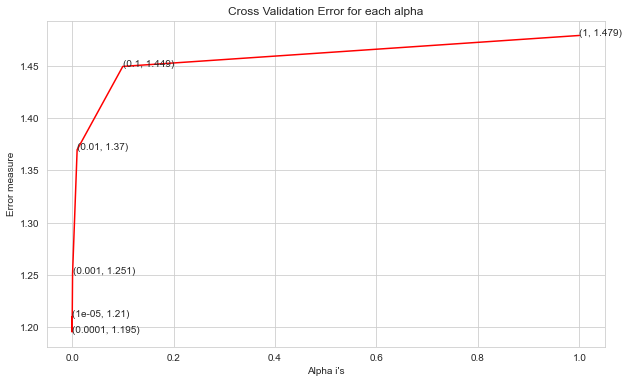

In [ ]:
# Determining the best Alpha value
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='red')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
# Using best alpha value from the above graph to compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.9930117400277069
For values of best alpha =  0.0001 The cross validation log loss is: 1.1953178455364262
For values of best alpha =  0.0001 The test log loss is: 1.1758558546014406


Checking overlapping between train, test or between validation and train

In [ ]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [ ]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 649 out of 665 : 97.59398496240601
2. In cross validation data 515 out of  532 : 96.80451127819549


## Evaluating Variation column

Variation is also a categorical variable and can be dealt with the same way as Gene column

In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1925
Truncating_Mutations    55
Deletion                52
Amplification           46
Fusions                 21
Overexpression           5
G12V                     3
Q61H                     2
TMPRSS2-ETV1_Fusion      2
G35R                     2
T73I                     2
Name: Variation, dtype: int64


Cumulative distribution of unique variation values

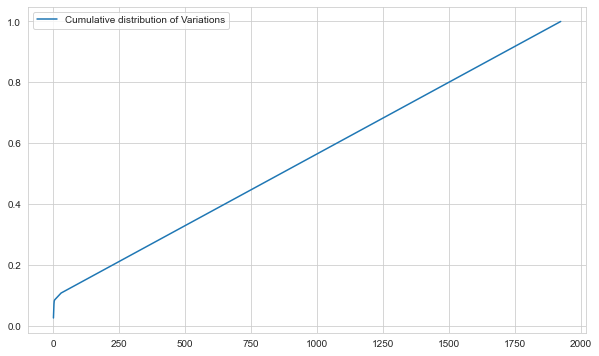

In [ ]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
plt.figure(figsize = (10,6))
plt.plot(c,label='Cumulative distribution of Variations')
plt.legend()
plt.show()

Converting variation column using one hot encoder

In [ ]:
# One-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Shape of one hot encoder column for variation

In [ ]:
train_variation_feature_onehotCoding.shape

(2124, 1952)

Generating response encoding for variation column

In [ ]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Shape of response encoding result

In [ ]:
train_variation_feature_responseCoding.shape

(2124, 9)

Building the model with variation column

In [ ]:
# Hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7187728320000426
For values of alpha =  0.0001 The log loss is: 1.7078935081231914
For values of alpha =  0.001 The log loss is: 1.70727434399397
For values of alpha =  0.01 The log loss is: 1.7167347249716214
For values of alpha =  0.1 The log loss is: 1.7366487145276648
For values of alpha =  1 The log loss is: 1.7379499696427028


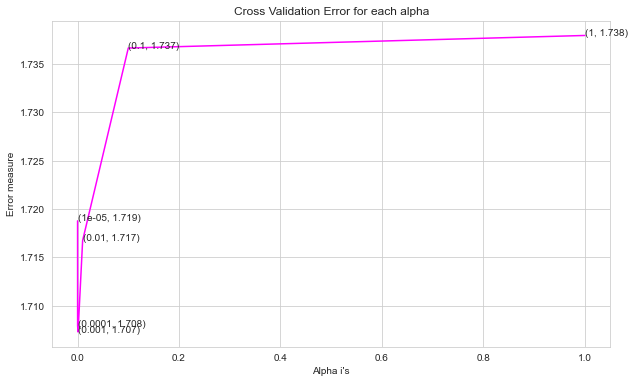

In [ ]:
# Plot to check the best Alpha value
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.068158095988339
For values of best alpha =  0.001 The cross validation log loss is: 1.70727434399397
For values of best alpha =  0.001 The test log loss is: 1.7079620722228164


In [ ]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 68 out of 665 : 10.225563909774436
2. In cross validation data 53 out of  532 : 9.962406015037594


## Evaluating Text column

In [ ]:


def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52008


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dictionary based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
# Converting each row value such that they sum to 1 
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# Normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# Normalizing every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# Normalizing every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
# Number of words for a given frequency
print(Counter(sorted_text_occur))

Counter({3: 4856, 4: 3581, 5: 2794, 6: 2460, 8: 2423, 9: 1890, 7: 1719, 10: 1450, 12: 1329, 11: 1097, 15: 988, 16: 934, 13: 878, 14: 772, 18: 665, 20: 594, 17: 584, 19: 529, 24: 505, 21: 498, 22: 428, 23: 413, 32: 376, 30: 369, 25: 353, 28: 352, 26: 343, 44: 317, 27: 317, 33: 297, 40: 274, 29: 273, 49: 260, 36: 251, 34: 251, 31: 225, 35: 219, 42: 218, 37: 208, 39: 194, 38: 194, 46: 178, 41: 173, 50: 170, 48: 168, 45: 167, 58: 161, 43: 161, 52: 152, 51: 148, 57: 143, 56: 143, 54: 143, 60: 141, 55: 135, 47: 133, 80: 121, 61: 119, 64: 118, 69: 116, 59: 113, 53: 113, 70: 109, 66: 109, 72: 104, 62: 104, 65: 100, 63: 99, 68: 91, 73: 90, 74: 89, 71: 88, 75: 87, 67: 84, 77: 83, 79: 82, 91: 77, 76: 75, 90: 74, 84: 73, 83: 73, 104: 69, 81: 69, 88: 68, 89: 67, 87: 66, 85: 66, 78: 65, 93: 64, 82: 64, 98: 62, 86: 60, 96: 59, 95: 57, 102: 56, 112: 55, 101: 55, 100: 55, 94: 54, 105: 52, 92: 52, 138: 49, 108: 49, 128: 48, 121: 48, 109: 48, 103: 48, 99: 48, 118: 46, 116: 46, 126: 45, 120: 45, 111: 45, 

Building the model with text column

In [ ]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.4672449292435714
For values of alpha =  0.0001 The log loss is: 1.3245547472347057
For values of alpha =  0.001 The log loss is: 1.3343111613693481
For values of alpha =  0.01 The log loss is: 1.4464352762341575
For values of alpha =  0.1 The log loss is: 1.5743123005824804
For values of alpha =  1 The log loss is: 1.7187018999654895


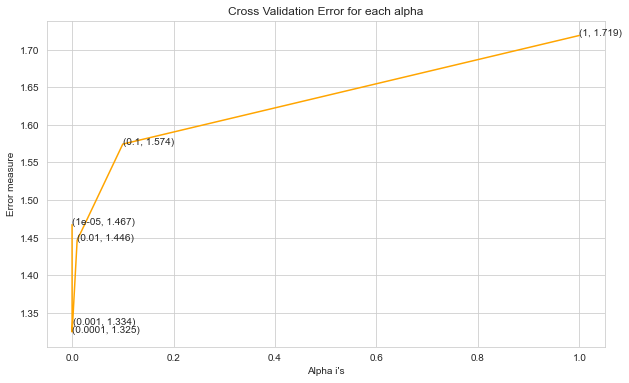

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.637191874613802
For values of best alpha =  0.0001 The cross validation log loss is: 1.3245547472347057
For values of best alpha =  0.0001 The test log loss is: 1.2058882337099506


Checking the overlap of text data

In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.958 % of word of test data appeared in train data
97.408 % of word of Cross Validation appeared in train data


## Data Preparation for Machine Learning models

Functions that will be used

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# Used to plot the confusion matrices
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss an array of probabilities is provided that belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
# Function for naive bayes
# for the given indices,the name of the features would be printed
# and it would be checked  whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [ ]:
# Merging gene, variation and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

### One-hot encoding
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

### Response Encoding
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [ ]:
print("One hot encoding features :")
print("(number of data points,number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points,number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points,number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points,number of features) in train data =  (2124, 54194)
(number of data points,number of features) in test data =  (665, 54194)
(number of data points,number of features) in cross validation data = (532, 54194)


In [ ]:
print(" Response encoding features :")
print("(number of data points,number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points,number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points,number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points,number of features) in train data =  (2124, 27)
(number of data points,number of features) in test data =  (665, 27)
(number of data points,number of features) in cross validation data = (532, 27)


## Building Machine Learning models

### Naive Bayes

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

For alpha = 1e-05
Log Loss : 1.3405879958818532
For alpha = 0.0001
Log Loss : 1.333729328103857
For alpha = 0.001
Log Loss : 1.327982517200206
For alpha = 0.1
Log Loss : 1.3010906608923245
For alpha = 1
Log Loss : 1.3349564796492244
For alpha = 10
Log Loss : 1.4476484407604788
For alpha = 100
Log Loss : 1.443107768409862
For alpha = 1000
Log Loss : 1.4199037213305592


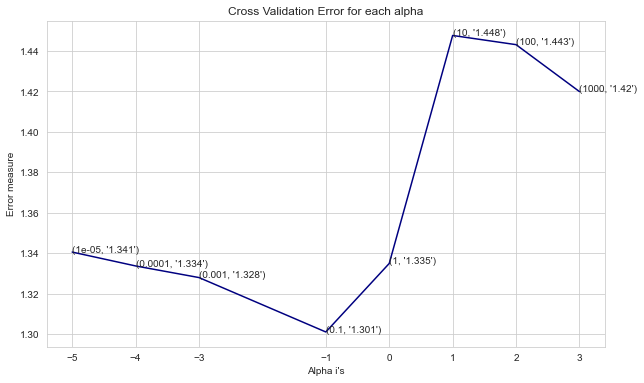

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(np.log10(alpha), cv_log_error_array,c='navy')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8338042990402318
For values of best alpha =  0.1 The cross validation log loss is: 1.3010906608923245
For values of best alpha =  0.1 The test log loss is: 1.2380580225379638


#### Testing Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.3010906608923245
Number of Misclassified points : 0.41353383458646614
-------------------- Confusion matrix --------------------


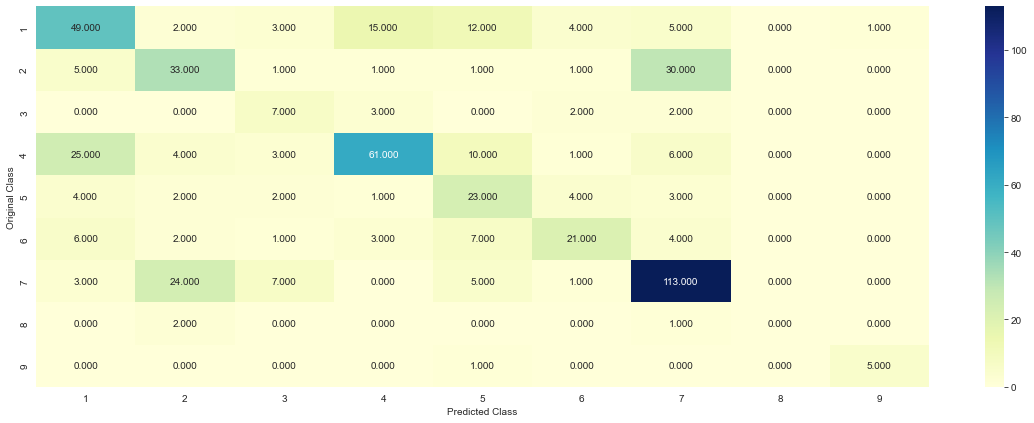

-------------------- Precision matrix (Columm Sum=1) --------------------


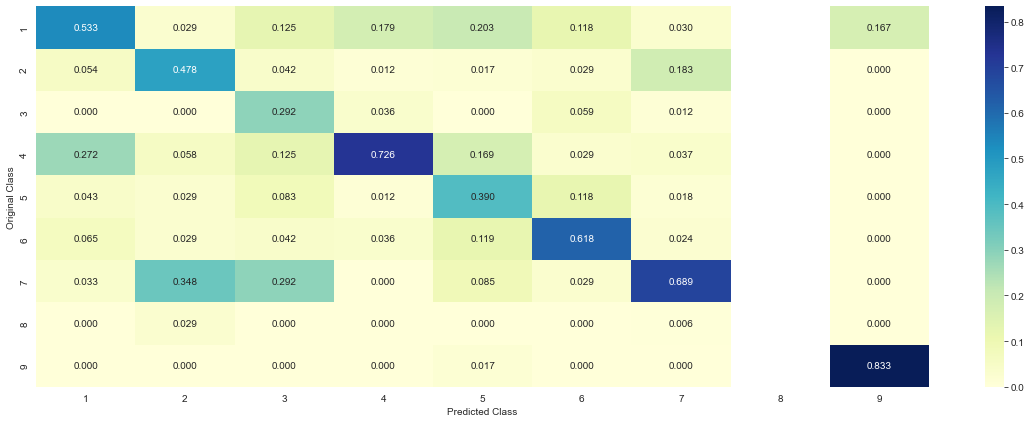

-------------------- Recall matrix (Row sum=1) --------------------


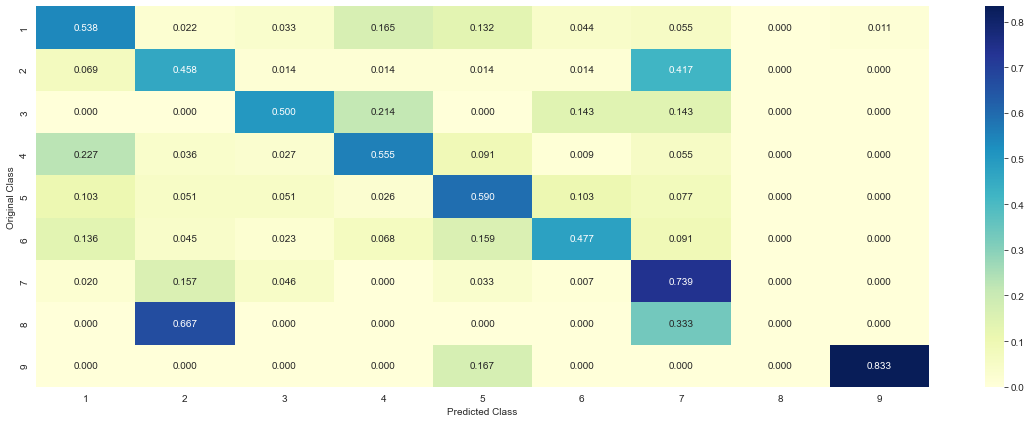

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of Misclassified points :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of the model

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.087  0.5553 0.0155 0.1114 0.0452 0.035  0.1397 0.006  0.0047]]
Actual Class : 2
--------------------------------------------------
18 Text feature [identified] present in test data point [True]
21 Text feature [sequencing] present in test data point [True]
22 Text feature [novel] present in test data point [True]
23 Text feature [detection] present in test data point [True]
24 Text feature [another] present in test data point [True]
25 Text feature [kinase] present in test data point [True]
26 Text feature [clinical] present in test data point [True]
27 Text feature [achieved] present in test data point [True]
28 Text feature [mutations] present in test data point [True]
29 Text feature [identification] present in test data point [True]
30 Text feature [including] present in test data point [True]
31 Text feature [molecular] present in test data point [True]
32 Text feature [using] present in test data point [True]
33 Text feature 

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0893 0.4833 0.0159 0.1144 0.0464 0.0358 0.2038 0.0062 0.0049]]
Actual Class : 7
--------------------------------------------------
18 Text feature [identified] present in test data point [True]
20 Text feature [harbored] present in test data point [True]
21 Text feature [sequencing] present in test data point [True]
22 Text feature [novel] present in test data point [True]
24 Text feature [another] present in test data point [True]
25 Text feature [kinase] present in test data point [True]
26 Text feature [clinical] present in test data point [True]
28 Text feature [mutations] present in test data point [True]
30 Text feature [including] present in test data point [True]
31 Text feature [molecular] present in test data point [True]
32 Text feature [using] present in test data point [True]
33 Text feature [present] present in test data point [True]
35 Text feature [confirmed] present in test data point [True]
36 Text feature [may] p

#### Naive Bayes is not performing very badly but lets look at other models

## K Nearest Neighbour Classification

In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1327114515572707
for alpha = 11
Log Loss : 1.1432493383891909
for alpha = 15
Log Loss : 1.1297040104382379
for alpha = 21
Log Loss : 1.1438168558181883
for alpha = 31
Log Loss : 1.1262465658600036
for alpha = 41
Log Loss : 1.1249640092746829
for alpha = 51
Log Loss : 1.1361516603992405
for alpha = 99
Log Loss : 1.1468029582365218


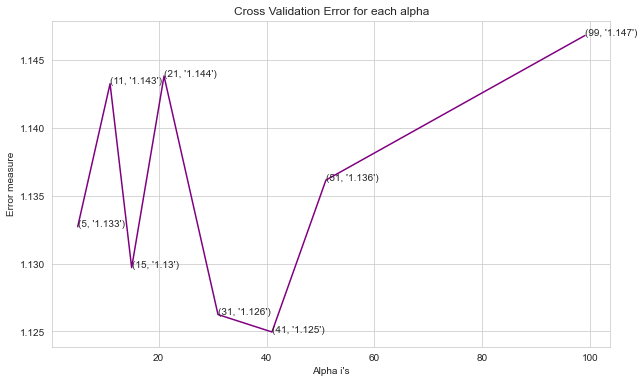

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='purple')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  41 The train log loss is: 0.8347333358605703
For values of best alpha =  41 The cross validation log loss is: 1.1249640092746829
For values of best alpha =  41 The test log loss is: 1.1300864348562587


Testing the model on test dataset with our best alpha value

Log loss : 1.1249640092746829
Number of mis-classified points : 0.41729323308270677
-------------------- Confusion matrix --------------------


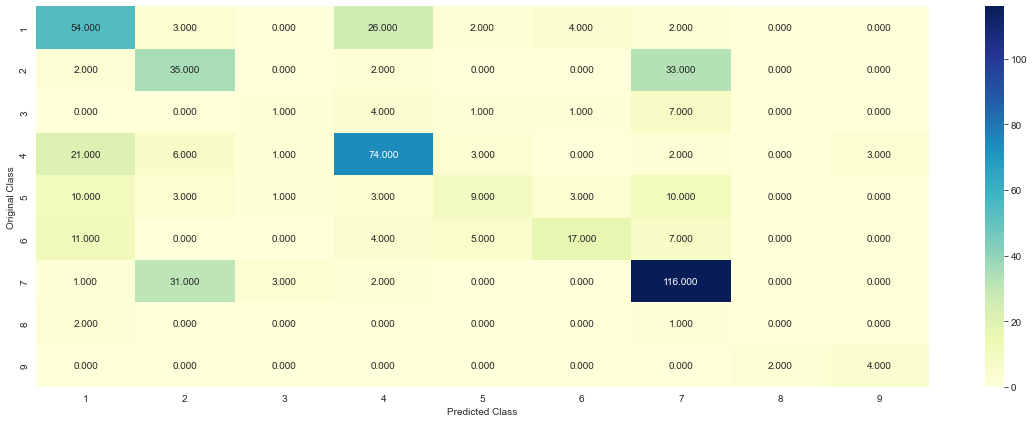

-------------------- Precision matrix (Columm Sum=1) --------------------


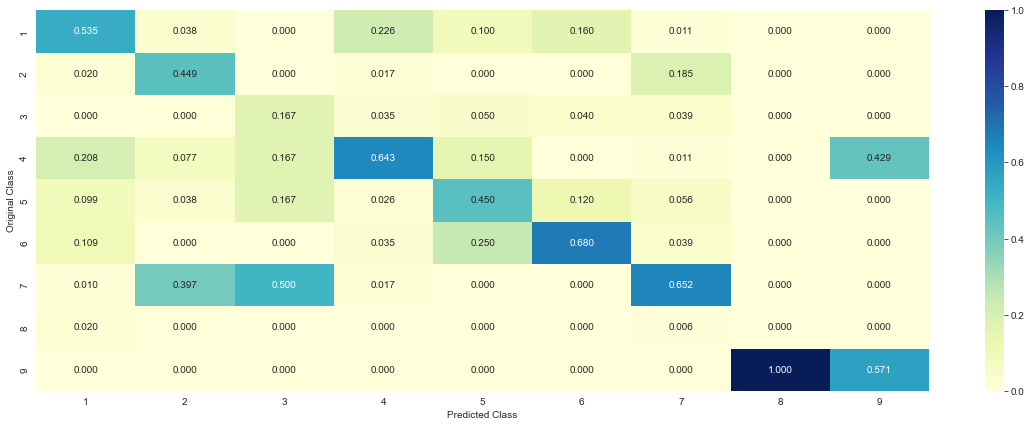

-------------------- Recall matrix (Row sum=1) --------------------


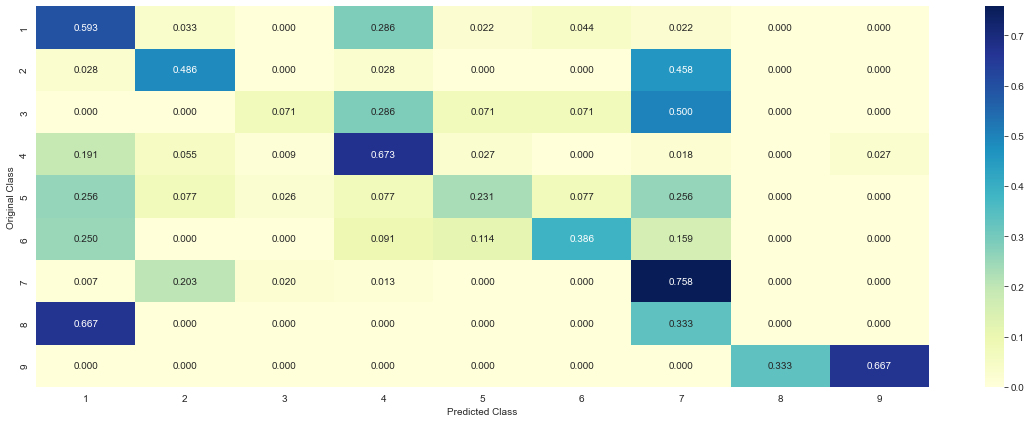

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Testing some data points

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 6
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  41  nearest neighbours of the test points belongs to classes [2 7 1 1 7 7 7 7 7 7 7 7 7 7 1 7 2 7 7 7 7 7 6 6 7 2 1 1 2 7 7 2 5 7 6 2 2
 7 7 7 6]
Fequency of nearest points : Counter({7: 24, 2: 7, 1: 5, 6: 4, 5: 1})


In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 105

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 41 and the nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 2 2 2 2 2 2 7 7 7 1 7 2 7 7 1 1 5 2 2 6 6 6 7 7 2 2 2 2 7 7
 7 2 2 2]
Fequency of nearest points : Counter({2: 23, 7: 11, 1: 3, 6: 3, 5: 1})


## Logistic Regression

#### Balancing all classes

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


For alpha = 1e-06
Log Loss : 1.525529377492278
For alpha = 1e-05
Log Loss : 1.4848914297937406
For alpha = 0.0001
Log Loss : 1.3207725565546995
For alpha = 0.001
Log Loss : 1.2844140351567999
For alpha = 0.01
Log Loss : 1.3220281007822212
For alpha = 0.1
Log Loss : 1.5381778317979788
For alpha = 1
Log Loss : 1.7388545410586238
For alpha = 10
Log Loss : 1.756079435353909
For alpha = 100
Log Loss : 1.757840928330266


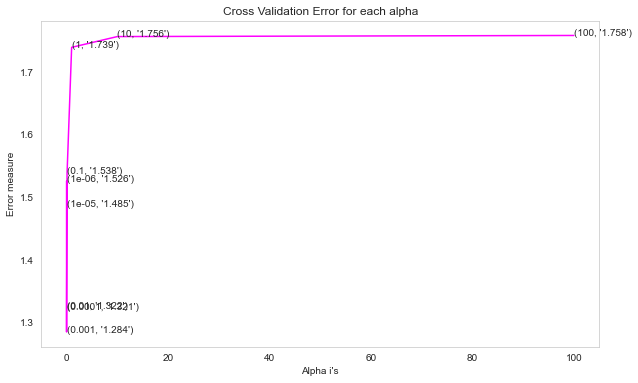

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5081490656894474
For values of best alpha =  0.001 The cross validation log loss is: 1.2844140351567999
For values of best alpha =  0.001 The test log loss is: 1.1169496603919944


### Testing on test data using best alpha value

Log loss : 1.2844140351567999
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


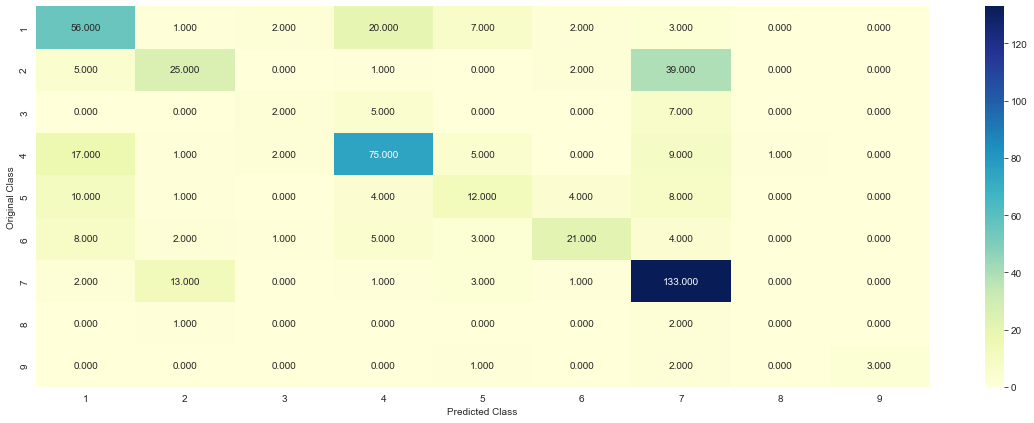

-------------------- Precision matrix (Columm Sum=1) --------------------


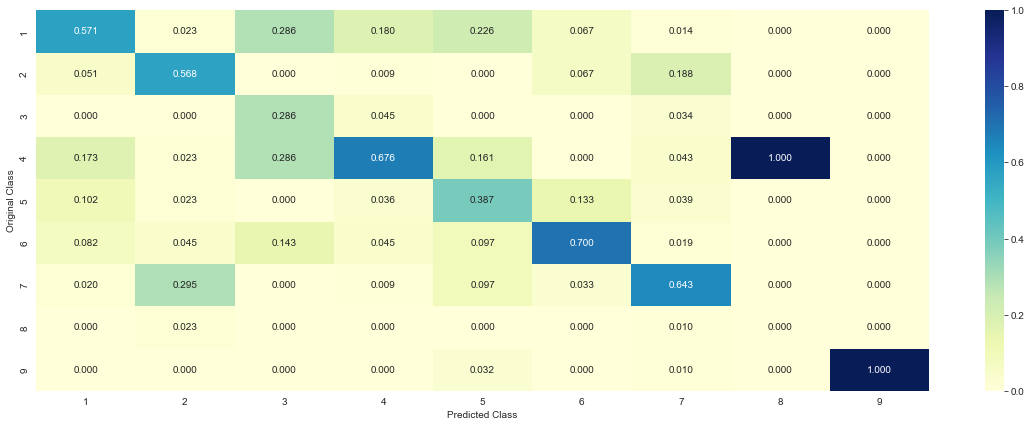

-------------------- Recall matrix (Row sum=1) --------------------


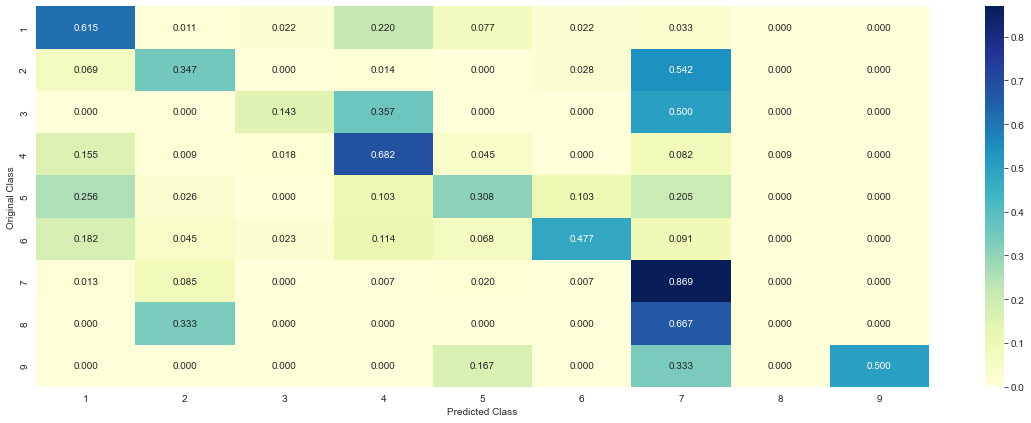

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### Testing query point and doing interpretability

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0055 0.9462 0.0047 0.0054 0.0139 0.0048 0.0102 0.0054 0.0039]]
Actual Class : 2
--------------------------------------------------
110 Text feature [e255k] present in test data point [True]
115 Text feature [y253h] present in test data point [True]
154 Text feature [ccyr] present in test data point [True]
158 Text feature [t315i] present in test data point [True]
206 Text feature [gimema] present in test data point [True]
299 Text feature [v299l] present in test data point [True]
310 Text feature [f317l] present in test data point [True]
332 Text feature [interindividual] present in test data point [True]
334 Text feature [y253f] present in test data point [True]
350 Text feature [leukemianet] present in test data point [True]
398 Text feature [advise] present in test data point [True]
424 Text feature [pcyr] present in test data point [True]
440 Text feature [abstracts] present in test data point [True]
488 Text feature [sound] pr

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1102 0.2074 0.0294 0.1462 0.0703 0.0451 0.3752 0.0061 0.0101]]
Actual Class : 7
--------------------------------------------------
28 Text feature [3t3] present in test data point [True]
45 Text feature [oncogene] present in test data point [True]
95 Text feature [activated] present in test data point [True]
205 Text feature [activation] present in test data point [True]
252 Text feature [transformation] present in test data point [True]
289 Text feature [technology] present in test data point [True]
320 Text feature [activating] present in test data point [True]
388 Text feature [expressing] present in test data point [True]
447 Text feature [downstream] present in test data point [True]
Out of the top  500  features  9 are present in query point


### Without class balancing

In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.446130870473239
for alpha = 1e-05
Log Loss : 1.463124556854643
for alpha = 0.0001
Log Loss : 1.3261385058624722
for alpha = 0.001
Log Loss : 1.3016277903025404
for alpha = 0.01
Log Loss : 1.3993859298193954
for alpha = 0.1
Log Loss : 1.5216381208836347
for alpha = 1
Log Loss : 1.6944725926729756


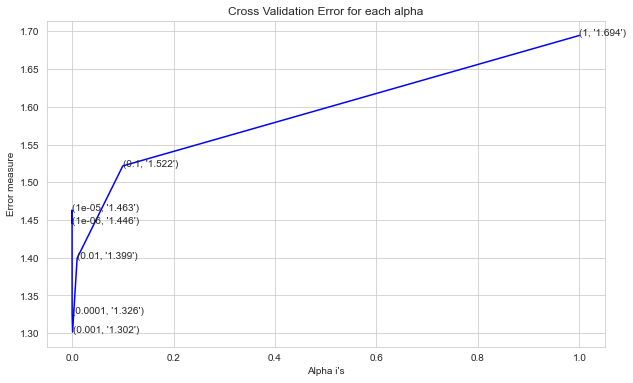

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='blue')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.49219141662711363
For values of best alpha =  0.001 The cross validation log loss is: 1.3016277903025404
For values of best alpha =  0.001 The test log loss is: 1.1225495964534915


### Testing the model with best hyper param

Log loss : 1.3016277903025404
Number of mis-classified points : 0.39285714285714285
-------------------- Confusion matrix --------------------


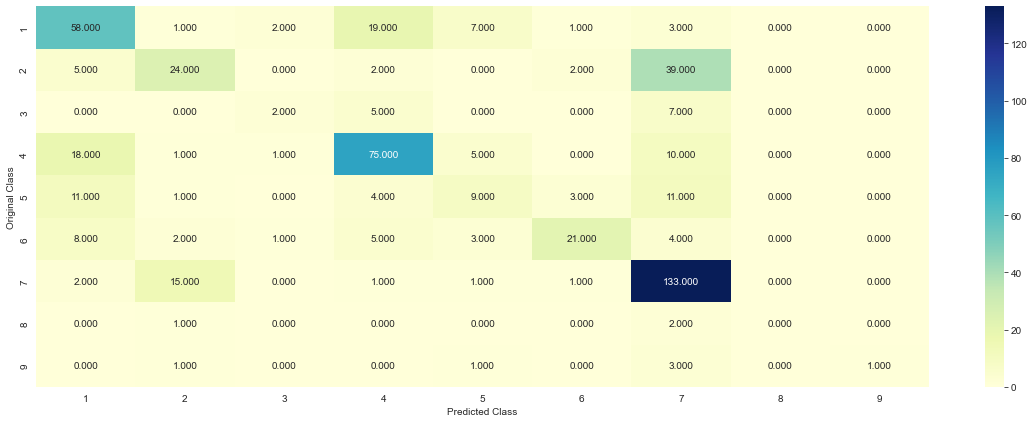

-------------------- Precision matrix (Columm Sum=1) --------------------


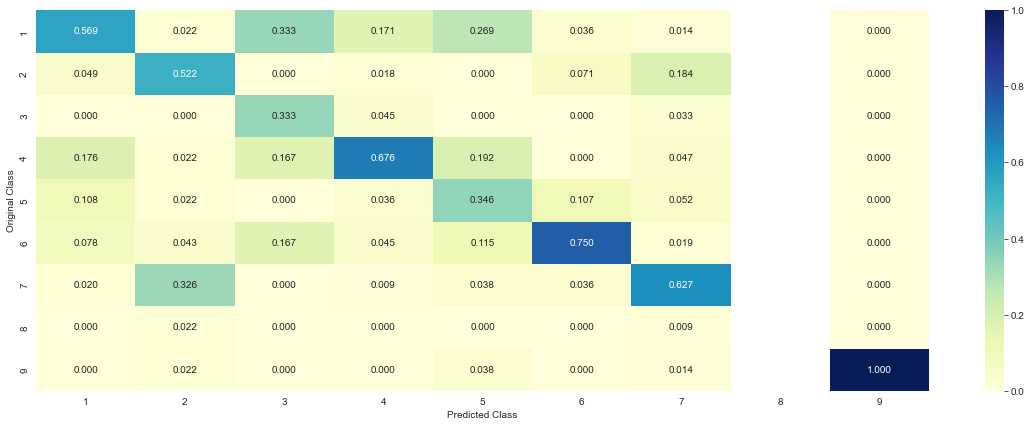

-------------------- Recall matrix (Row sum=1) --------------------


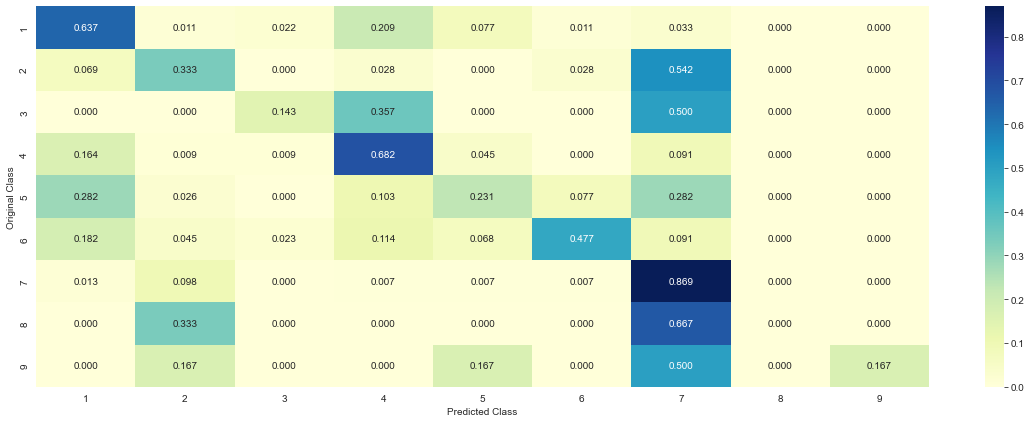

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Testing query point and interpretability

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[5.800e-03 9.497e-01 4.300e-03 5.400e-03 1.360e-02 4.600e-03 1.180e-02
  3.900e-03 9.000e-04]]
Actual Class : 2
--------------------------------------------------
123 Text feature [e255k] present in test data point [True]
129 Text feature [y253h] present in test data point [True]
167 Text feature [ccyr] present in test data point [True]
179 Text feature [t315i] present in test data point [True]
235 Text feature [gimema] present in test data point [True]
312 Text feature [v299l] present in test data point [True]
343 Text feature [f317l] present in test data point [True]
356 Text feature [y253f] present in test data point [True]
374 Text feature [interindividual] present in test data point [True]
384 Text feature [leukemianet] present in test data point [True]
405 Text feature [advise] present in test data point [True]
454 Text feature [abstracts] present in test data point [True]
460 Text feature [pcyr] present in test data point [True

## Linear Support Vector Machines

For C = 1e-05
Log Loss : 1.4850274747038281
For C = 0.0001
Log Loss : 1.3728846641871968
For C = 0.001
Log Loss : 1.2879888004320357
For C = 0.01
Log Loss : 1.27862784839991
For C = 0.1
Log Loss : 1.4391520022148308
For C = 1
Log Loss : 1.759293069317317
For C = 10
Log Loss : 1.758207983428532
For C = 100
Log Loss : 1.7582088852549378


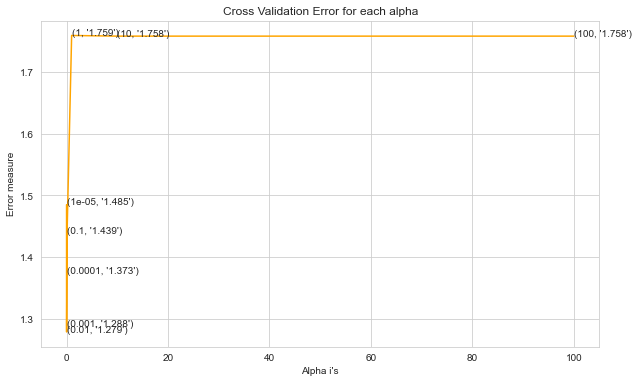

For values of best alpha =  0.01 The train log loss is: 0.7178527678032585
For values of best alpha =  0.01 The cross validation log loss is: 1.27862784839991
For values of best alpha =  0.01 The test log loss is: 1.155955461983535


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("For C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Querying some correctly classified point

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0385 0.8102 0.0092 0.032  0.0308 0.0165 0.0556 0.0041 0.003 ]]
Actual Class : 2
--------------------------------------------------
13 Text feature [y253h] present in test data point [True]
14 Text feature [ccyr] present in test data point [True]
33 Text feature [e255k] present in test data point [True]
40 Text feature [gimema] present in test data point [True]
42 Text feature [v299l] present in test data point [True]
59 Text feature [leukemianet] present in test data point [True]
67 Text feature [t315i] present in test data point [True]
106 Text feature [f317l] present in test data point [True]
129 Text feature [pcyr] present in test data point [True]
134 Text feature [m351t] present in test data point [True]
155 Text feature [y253f] present in test data point [True]
168 Text feature [interindividual] present in test data point [True]
170 Text feature [f486s] present in test data point [True]
186 Text feature [cml] present in test 

## Random Forest Classifier

### Model with One hot encoder

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.3028777773449207
for n_estimators = 100 and max depth =  10
Log Loss : 1.216754120740516
for n_estimators = 200 and max depth =  5
Log Loss : 1.2940075344150932
for n_estimators = 200 and max depth =  10
Log Loss : 1.2135943365753081
for n_estimators = 500 and max depth =  5
Log Loss : 1.288516346869715
for n_estimators = 500 and max depth =  10
Log Loss : 1.2117036509997654
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2883983110975077
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2080410815694964
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2876977456616903
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2062540755731626


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6833646071546681
For values of best estimator =  2000 The cross validation log loss is: 1.2062540755731626
For values of best estimator =  2000 The test log loss is: 1.1354907044699905


### Testing on test data using best hyper param

Log loss : 1.2062540755731626
Number of mis-classified points : 0.3890977443609023
-------------------- Confusion matrix --------------------


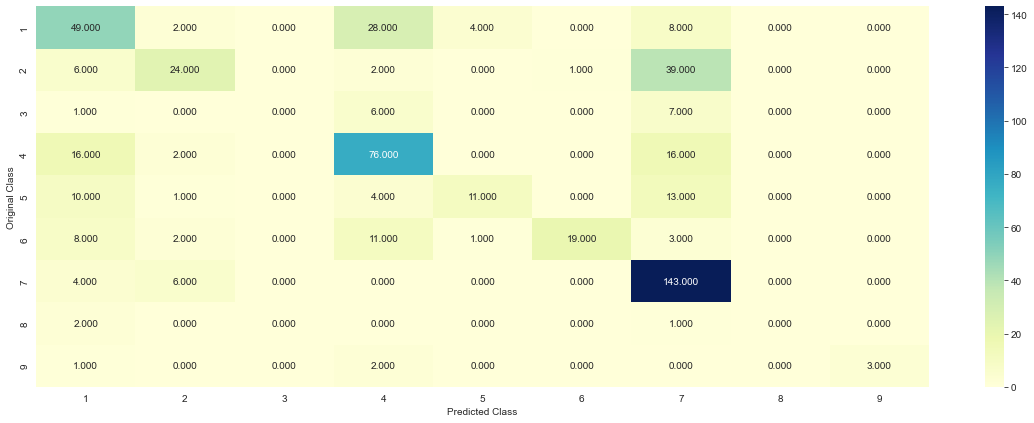

-------------------- Precision matrix (Columm Sum=1) --------------------


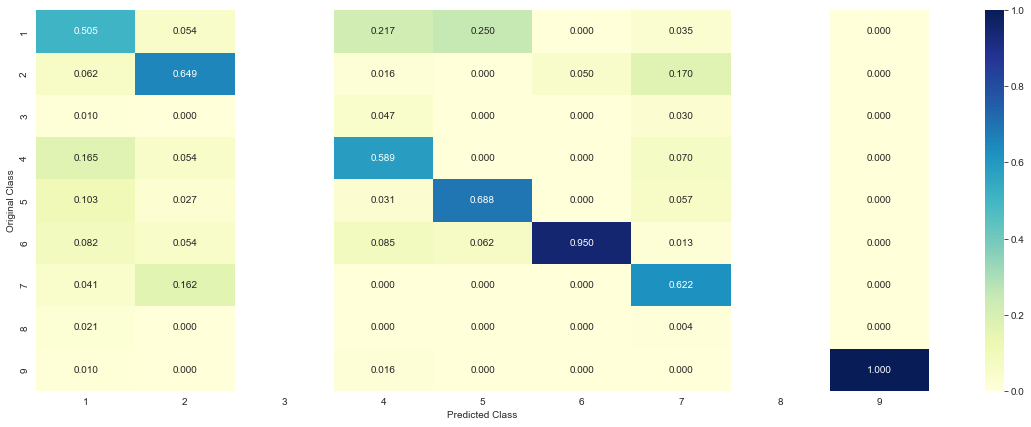

-------------------- Recall matrix (Row sum=1) --------------------


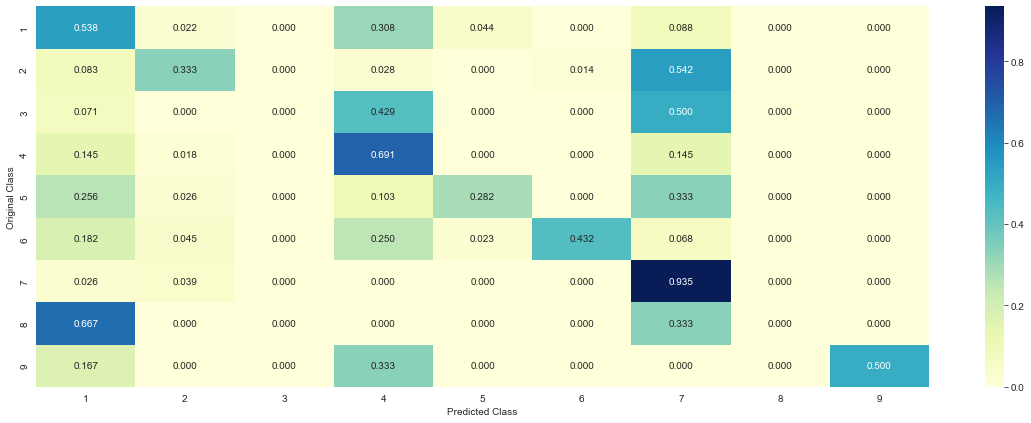

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0369 0.8112 0.0136 0.0265 0.0354 0.0274 0.0418 0.0036 0.0036]]
Actual Class : 2
--------------------------------------------------
1 Text feature [kinase] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [activation] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
24 Text feature [therapy] present in test data point [True]
28 Text feature [loss] present in test data point [True]
33 Text feature [therapeutic] present in test data point [True]
35 Text feature [cell] present in test data point [True]
37 Text feature [trials] present in test data point [True]
39 Text feature [inhibition] present in test data point [True]
42 Text feature [efficacy] present in test data point [True]
43 Text feature [cells] pres

### Random Forest with Response Coding

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.2305945944280983
for n_estimators = 10 and max depth =  3
Log Loss : 1.5025762006917014
for n_estimators = 10 and max depth =  5
Log Loss : 1.4920367694325738
for n_estimators = 10 and max depth =  10
Log Loss : 1.6273461353911929
for n_estimators = 50 and max depth =  2
Log Loss : 1.690206969664186
for n_estimators = 50 and max depth =  3
Log Loss : 1.4078999586725418
for n_estimators = 50 and max depth =  5
Log Loss : 1.5403585416410555
for n_estimators = 50 and max depth =  10
Log Loss : 1.6553617693579217
for n_estimators = 100 and max depth =  2
Log Loss : 1.533141953830446
for n_estimators = 100 and max depth =  3
Log Loss : 1.4981511174424322
for n_estimators = 100 and max depth =  5
Log Loss : 1.449574332382478
for n_estimators = 100 and max depth =  10
Log Loss : 1.6680417032087973
for n_estimators = 200 and max depth =  2
Log Loss : 1.5874145449688761
for n_estimators = 200 and max depth =  3
Log Loss : 1.5377680801207638


### Testing model with best hyper param

Log loss : 1.4078999586725418
Number of mis-classified points : 0.48872180451127817
-------------------- Confusion matrix --------------------


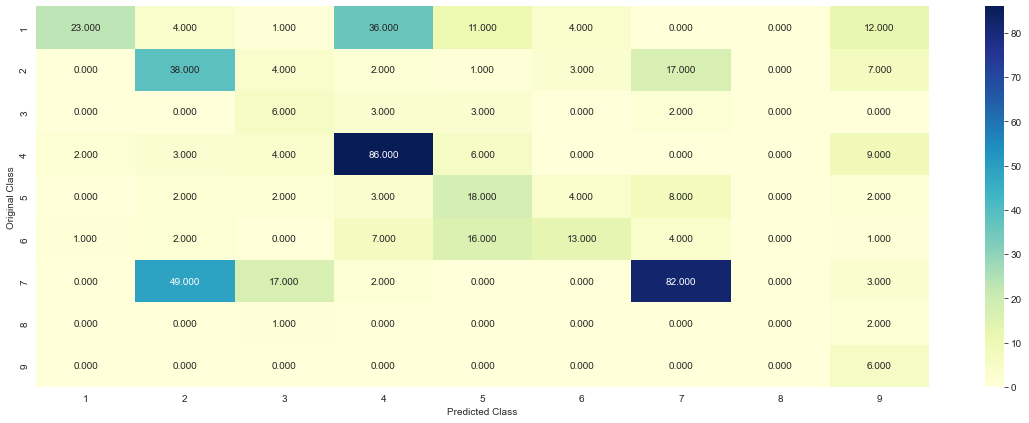

-------------------- Precision matrix (Columm Sum=1) --------------------


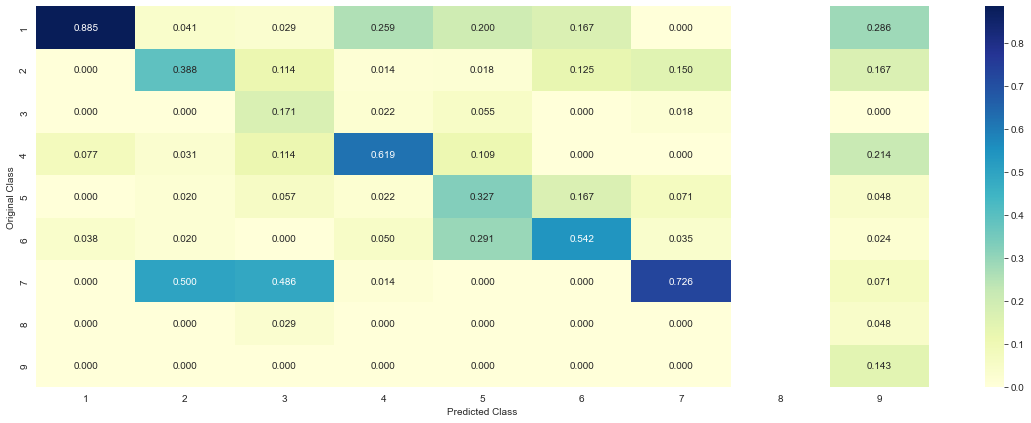

-------------------- Recall matrix (Row sum=1) --------------------


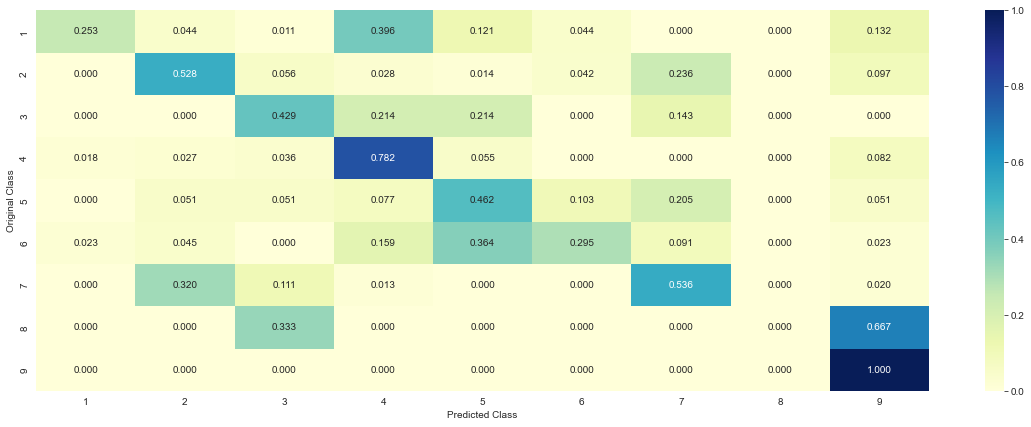

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Query the classified point

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0282 0.5118 0.0835 0.0201 0.0323 0.0326 0.0226 0.075  0.1938]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature


Log loss (train) on the stacking classifier : 0.4852213271277535
Log loss (CV) on the stacking classifier : 1.2994424334112118
Log loss (test) on the stacking classifier : 1.1741437395930845
Number of misclassified point : 0.35789473684210527
-------------------- Confusion matrix --------------------


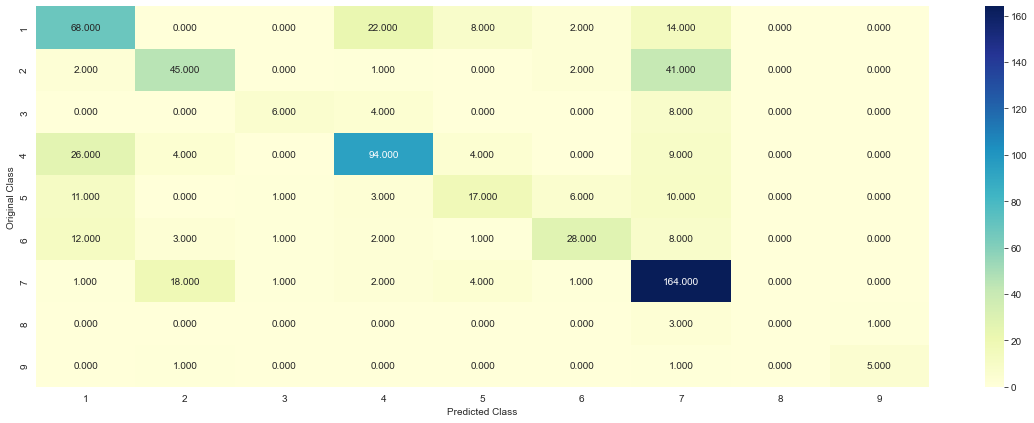

-------------------- Precision matrix (Columm Sum=1) --------------------


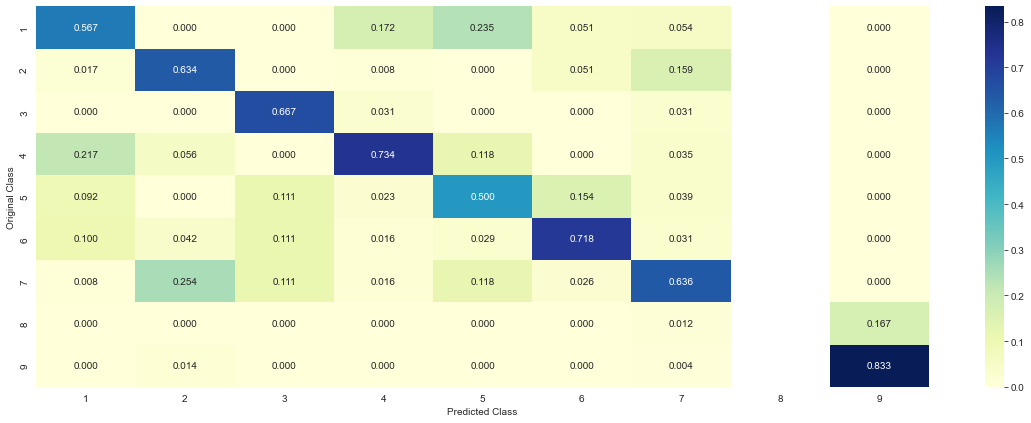

-------------------- Recall matrix (Row sum=1) --------------------


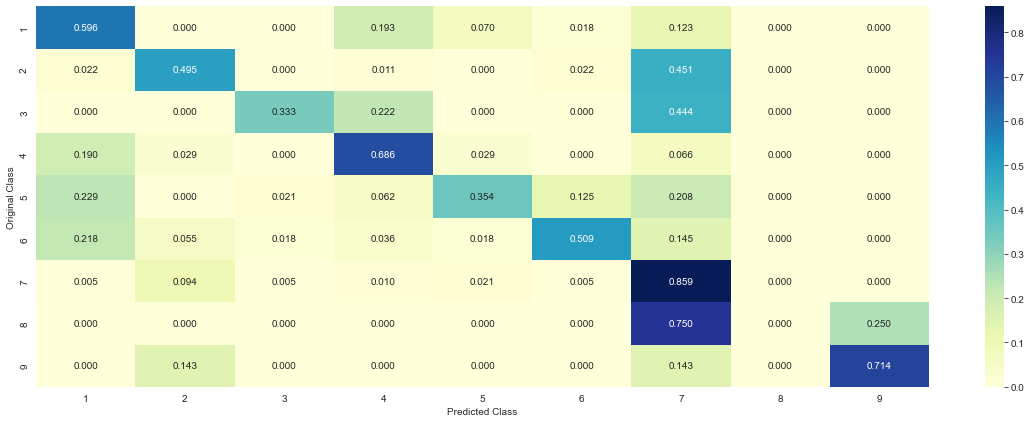

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of misclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))